## Теоретическая часть

**1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи?**

Отличия: User-User ищем похожих пользователей, рекомендуем товары похожих пользователей

Item-Item находим элементы, похожие на те, с которыми пользователь уже «положительно» взаимодействовал

Похожи: структурой матрицы (Квадратные, на пересечении будут совпавшие товары или пользователи). 

**Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?**

Можно, но нужно транспорнировать матрицу, пользователи - строки, столбцы - товары.

**В чем принципиальные отличия item-item рекомендаций от ALS?**

item-item - алгоритм К ближайших соседей, а ALS - Градиентного спуск. 
ALS быстрее и меньше места занимает, так как разбивает на 2 матрицы. ALS заполняет пропуски в матрице взаимодействия, item-item нет.

**2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров**

частота покупок, длительность взаимодействия (нахождения на странице товара, просмотр видео и тд), количество взаимодействия,
добавление в корзину

**3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)**

учитывает только, если было взаимодействие пользователь-товар и наоборот

не учитывает нелинейные зависимости


## Практическая часть


In [181]:
#!pip install implicit

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys


In [183]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [184]:
data['day'].nunique()

663

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [185]:
from ipynb.fs.full.my_metrics import precision_at_k

In [186]:
# создадим таблички для результатов по трейн и тест
result_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
result_train.columns=['user_id', 'actual']

result_test = data_test.groupby('user_id')['item_id'].unique().reset_index()
result_test.columns=['user_id', 'actual']

In [187]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [188]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [189]:
#user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 
#user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [190]:
title_list = ['quantity-count', 'quantity-mean', 'sales_value-mean', 'trans_time-mean', 'week_no-max']
values_list = ['quantity', 'quantity', 'sales_value', 'trans_time', 'week_no']
aggfunc_list = [np.count_nonzero, np.mean, np.sum, np.mean, np.max]

for i in range(len(values_list)):
    
    user_item_matrix = pd.pivot_table(data_train, 
                                      index='user_id', columns='item_id', 
                                      values=values_list[i], # Можно пробоват другие варианты
                                      aggfunc=aggfunc_list[i], 
                                      fill_value=0
                                     )

    user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

    # переведем в формат saprse matrix
    sparse_user_item = csr_matrix(user_item_matrix).tocsr()

    userids = user_item_matrix.index.values
    itemids = user_item_matrix.columns.values

    matrix_userids = np.arange(len(userids))
    matrix_itemids = np.arange(len(itemids))

    id_to_itemid = dict(zip(matrix_itemids, itemids))
    id_to_userid = dict(zip(matrix_userids, userids))

    itemid_to_id = dict(zip(itemids, matrix_itemids))
    userid_to_id = dict(zip(userids, matrix_userids))
    
    #user_item_matrix = bm25_weight(user_item_matrix.T).T # применим bm25
    
    model = AlternatingLeastSquares(factors=44, 
                                    regularization=0.01, #поставила побольше, вместо 0.001, тк большое переобучение
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    use_gpu=False)

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=True)
    
    result_train['als_' + title_list[i]] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    result_test['als_' + title_list[i]] = result_test['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [191]:
#[id_to_itemid[rec[0]] for rec in recs]
result_train.head(3)

,user_id,actual,als_quantity-count,als_quantity-mean,als_sales_value-mean,als_trans_time-mean,als_week_no-max
0,1,"[825123, 831447, 840361, 845307, 852014, 85498...","[1005186, 1033142, 5569374, 999999, 1082185]","[986947, 820165, 1082185, 999999, 1127831]","[1100972, 5569374, 901062, 1105488, 878996]","[982393, 999730, 1059347, 1096290, 988416]","[1004390, 891961, 900842, 960732, 826952]"
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55...","[999999, 1133018, 5569230, 1106523, 1082185]","[833715, 1007195, 1003421, 903674, 979746]","[5569230, 999999, 6534178, 916122, 5569845]","[1015785, 6704035, 849870, 8090539, 930666]","[5582712, 830775, 13095243, 7024830, 1006649]"
2,3,"[866211, 878996, 882830, 904360, 921345, 93194...","[951590, 5568378, 1092026, 1106523, 1053690]","[938700, 1022003, 1013321, 822407, 929668]","[1022003, 909894, 965766, 908531, 951590]","[1029685, 838563, 8090519, 838602, 1093113]","[1043971, 1110292, 12185599, 1027068, 913278]"


In [192]:
result_test.head(3)

,user_id,actual,als_quantity-count,als_quantity-mean,als_sales_value-mean,als_trans_time-mean,als_week_no-max
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1005186, 1033142, 5569374, 999999, 1082185]","[986947, 820165, 1082185, 999999, 1127831]","[1100972, 5569374, 901062, 1105488, 878996]","[982393, 999730, 1059347, 1096290, 988416]","[1004390, 891961, 900842, 960732, 826952]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[951590, 5568378, 1092026, 1106523, 1053690]","[938700, 1022003, 1013321, 822407, 929668]","[1022003, 909894, 965766, 908531, 951590]","[1029685, 838563, 8090519, 838602, 1093113]","[1043971, 1110292, 12185599, 1027068, 913278]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[878996, 1024306, 1023720, 1007195, 1051516]","[1082185, 999999, 878996, 860776, 1024306]","[1051516, 1007195, 930118, 871611, 1105488]","[1048727, 1110632, 977481, 1114050, 869344]","[906017, 929704, 1042616, 12648967, 5565352]"


In [193]:
%%time

metrics_train = {}
metrics_test = {}

for i in result_train.columns[1:]:
    metrics_train[i] = result_train.apply(lambda row: precision_at_k(row[i], row['actual'],5), axis=1).mean()
    metrics_test[i] = result_test.apply(lambda row: precision_at_k(row[i], row['actual'],5), axis=1).mean()

CPU times: user 2.25 s, sys: 30 ms, total: 2.28 s
Wall time: 1.95 s


In [194]:
metrics_train

{'actual': 1.0,
 'als_quantity-count': 0.6177671068427305,
 'als_quantity-mean': 0.6952380952380783,
 'als_sales_value-mean': 0.5118847539015596,
 'als_trans_time-mean': 0.029371748699479887,
 'als_week_no-max': 0.0942777110844331}

In [195]:
title_list.insert(0, 'actual')

In [196]:
scores = pd.DataFrame(list(zip(title_list, metrics_train.values(), metrics_test.values()))[1:], columns=['weight','precision_ak_train', 'precision_ak_test'])

scores.sort_values(['precision_ak_test'], ascending = False)

,weight,precision_ak_train,precision_ak_test
1,quantity-mean,0.695238,0.170715
0,quantity-count,0.617767,0.167679
2,sales_value-mean,0.511885,0.104505
4,week_no-max,0.094278,0.015279
3,trans_time-mean,0.029372,0.005877


**Самым значимым весом оказалось среднее количество товара, видимо, оно лучше отражает взаимодействие пользователя с товаром. На втором месте количество товаров. Сумма продажи оказалась менее важна, чем количество.**

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы
**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!

**возьмем вес - количество товара, по среднему значению**

In [197]:
# создадим таблички для результатов по трейн и тест
result_train_opt = data_train.groupby('user_id')['item_id'].unique().reset_index()
result_train_opt.columns=['user_id', 'actual']

result_test_opt = data_test.groupby('user_id')['item_id'].unique().reset_index()
result_test_opt.columns=['user_id', 'actual']

In [198]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [199]:
#user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 
#user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [200]:
user_item_matrix = pd.pivot_table(data_train, 
                                      index='user_id', columns='item_id', 
                                      values='quantity', 
                                      aggfunc=np.mean, 
                                      fill_value=0
                                     )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))
    
#user_item_matrix = bm25_weight(user_item_matrix.T).T # применим bm25

import time
time_start = time.perf_counter()
time_list = []
for i in range(6):
    print(i**i)
    time_finish = time.perf_counter()
    time_list.append(time_finish-time_start)
    print(f"Вычисление заняло {time_finish-time_start} секунд")
    time_start = time_finish
    
time_list

In [201]:
import time
time_start = time.perf_counter()
#time_list = []
total_step = []
total = []
factor_list = [10, 30, 50, 100, 150]
lambda_list = [1, 0.01, 0.001]
for f_index in range(len(factor_list)):
    for l_index in range(len(lambda_list)):
    
        model = AlternatingLeastSquares(factors=factor_list[f_index], 
                                        regularization=lambda_list[l_index],
                                        iterations=15, 
                                        calculate_training_loss=True, #num_threads=4, K - кол-во билжайших соседей
                                        use_gpu=False)

        model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
                    show_progress=True)

        result_train_opt['als_' + str(factor_list[f_index]) + "_" + str(lambda_list[l_index])] = result_train_opt['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        result_test_opt['als_' + str(factor_list[f_index]) + "_" + str(lambda_list[l_index])] = result_test_opt['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        
        time_finish = time.perf_counter()
        #time_list.append(time_finish-time_start)
        #print(f"Вычисление заняло {time_finish-time_start} секунд")
        total_step.append([str(factor_list[f_index]) + "_" + str(lambda_list[l_index]), time_finish-time_start])
        #print(total_step)
        time_start = time_finish
    total.append(total_step)
    #print(total)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

<AxesSubplot:>

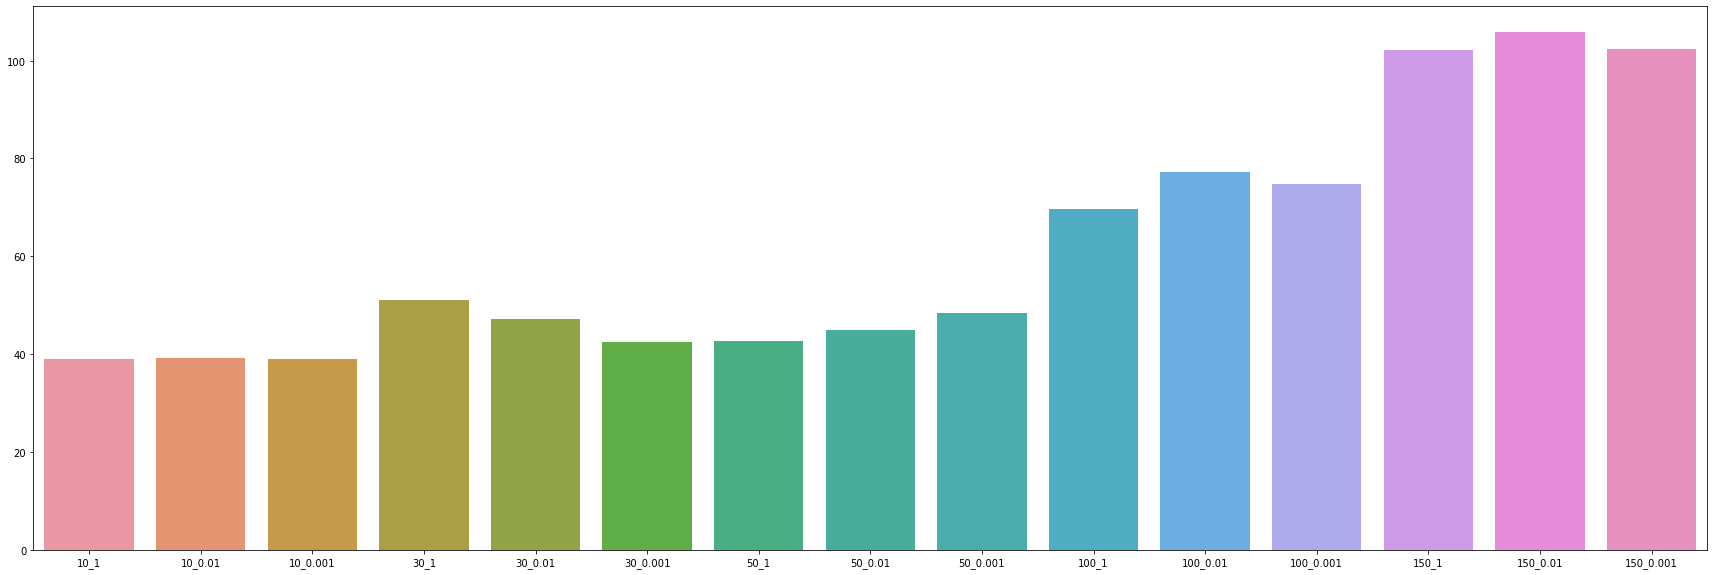

In [202]:
# график значение параметра - время обучения 
import seaborn
plt.figure(figsize=(30,10)) 

x_title = [total[0][i][0] for i in range(len(total[0]))]
y_time =  [total[0][i][1] for i in range(len(total[0]))]

seaborn.barplot(x=x_title, y=y_time)

**время обучения больше, если больше фактор и меньше лямбда**

In [203]:
#[id_to_itemid[rec[0]] for rec in recs]
result_train_opt.head(3)

,user_id,actual,als_10_1,als_10_0.01,als_10_0.001,als_30_1,als_30_0.01,als_30_0.001,als_50_1,als_50_0.01,als_50_0.001,als_100_1,als_100_0.01,als_100_0.001,als_150_1,als_150_0.01,als_150_0.001
0,1,"[999999, 840361, 845307, 852014, 856942, 91267...","[1082185, 1127831, 1007195, 999999, 961554]","[1082185, 999999, 1127831, 981760, 1007195]","[1082185, 1127831, 999999, 1007195, 860776]","[999999, 1082185, 820165, 1127831, 986947]","[999999, 1082185, 1127831, 981760, 995242]","[1082185, 999999, 1127831, 986947, 820165]","[820165, 986947, 999999, 1082185, 866227]","[986947, 820165, 1082185, 999999, 1005186]","[820165, 866227, 999999, 1082185, 986947]","[820165, 986947, 1082185, 866227, 995242]","[820165, 995242, 986947, 1082185, 907014]","[986947, 820165, 1082185, 995242, 907014]","[986947, 1082185, 999999, 820165, 995242]","[986947, 1082185, 820165, 995242, 986912]","[907014, 1082185, 999999, 820165, 986947]"
1,2,"[854852, 930118, 1077555, 1098066, 999999, 556...","[1082185, 999999, 981760, 1127831, 1007195]","[999999, 1082185, 981760, 1007195, 995785]","[999999, 1082185, 1007195, 981760, 1127831]","[911878, 833715, 1007195, 999999, 1003421]","[1007195, 833715, 1003421, 903674, 911878]","[833715, 911878, 1003421, 999999, 1007195]","[833715, 999999, 1003421, 903674, 911878]","[903674, 833715, 979746, 1003421, 1007195]","[833715, 903674, 999999, 1003421, 1007195]","[833715, 903674, 911878, 979746, 1007195]","[833715, 903674, 1003421, 1068719, 911878]","[833715, 853904, 1068719, 911878, 903674]","[833715, 853904, 903674, 911878, 979746]","[833715, 903674, 1007195, 1003421, 1068719]","[833715, 911878, 1068719, 853904, 903674]"
2,3,"[866211, 878996, 882830, 904360, 921345, 99999...","[999999, 6534178, 883404, 1082185, 1098066]","[951590, 6534178, 5569230, 910032, 826249]","[910032, 6534178, 826249, 951590, 1098066]","[6534178, 5569230, 910032, 951590, 930917]","[6534178, 862139, 951590, 5569230, 910032]","[929668, 938700, 830750, 844165, 1013321]","[1022003, 938700, 822407, 1013321, 6534178]","[938700, 844165, 910032, 1022003, 1044078]","[938700, 844165, 1106523, 925514, 1013321]","[938700, 1133018, 1106523, 1044078, 1022003]","[938700, 1044078, 1133018, 910032, 1106523]","[910032, 951590, 1133018, 938700, 1106523]","[1133018, 1106523, 951590, 938700, 9526563]","[1106523, 1133018, 1022003, 9337581, 1044078]","[1106523, 1022003, 938700, 1133018, 1092026]"


In [204]:
result_test_opt.head(3)

,user_id,actual,als_10_1,als_10_0.01,als_10_0.001,als_30_1,als_30_0.01,als_30_0.001,als_50_1,als_50_0.01,als_50_0.001,als_100_1,als_100_0.01,als_100_0.001,als_150_1,als_150_0.01,als_150_0.001
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082185, 1127831, 1007195, 999999, 961554]","[1082185, 999999, 1127831, 981760, 1007195]","[1082185, 1127831, 999999, 1007195, 860776]","[999999, 1082185, 820165, 1127831, 986947]","[999999, 1082185, 1127831, 981760, 995242]","[1082185, 999999, 1127831, 986947, 820165]","[820165, 986947, 999999, 1082185, 866227]","[986947, 820165, 1082185, 999999, 1005186]","[820165, 866227, 999999, 1082185, 986947]","[820165, 986947, 1082185, 866227, 995242]","[820165, 995242, 986947, 1082185, 907014]","[986947, 820165, 1082185, 995242, 907014]","[986947, 1082185, 999999, 820165, 995242]","[986947, 1082185, 820165, 995242, 986912]","[907014, 1082185, 999999, 820165, 986947]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[999999, 6534178, 883404, 1082185, 1098066]","[951590, 6534178, 5569230, 910032, 826249]","[910032, 6534178, 826249, 951590, 1098066]","[6534178, 5569230, 910032, 951590, 930917]","[6534178, 862139, 951590, 5569230, 910032]","[929668, 938700, 830750, 844165, 1013321]","[1022003, 938700, 822407, 1013321, 6534178]","[938700, 844165, 910032, 1022003, 1044078]","[938700, 844165, 1106523, 925514, 1013321]","[938700, 1133018, 1106523, 1044078, 1022003]","[938700, 1044078, 1133018, 910032, 1106523]","[910032, 951590, 1133018, 938700, 1106523]","[1133018, 1106523, 951590, 938700, 9526563]","[1106523, 1133018, 1022003, 9337581, 1044078]","[1106523, 1022003, 938700, 1133018, 1092026]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[999999, 1082185, 6534178, 1127831, 1007195]","[999999, 1082185, 1127831, 6533889, 6534178]","[999999, 1082185, 1127831, 1007195, 820165]","[999999, 1082185, 1007195, 878996, 820165]","[1082185, 999999, 878996, 860776, 1024306]","[1082185, 999999, 1127831, 878996, 860776]","[999999, 1082185, 878996, 1127831, 820165]","[999999, 1082185, 878996, 1127831, 1024306]","[1082185, 878996, 1127831, 999999, 1024306]","[999999, 1082185, 878996, 820165, 1024306]","[999999, 1082185, 1024306, 1127831, 878996]","[999999, 1082185, 878996, 1024306, 1127831]","[878996, 1082185, 999999, 1127831, 981760]","[999999, 1082185, 866211, 878996, 866227]","[1082185, 999999, 878996, 1024306, 5569230]"


In [205]:
%%time

metrics_train_opt = {}
metrics_test_opt = {}

for i in result_train_opt.columns[1:]:
    metrics_train_opt[i] = result_train_opt.apply(lambda row: precision_at_k(row[i], row['actual'],5), axis=1).mean()
    metrics_test_opt[i] = result_test_opt.apply(lambda row: precision_at_k(row[i], row['actual'],5), axis=1).mean()

CPU times: user 5.02 s, sys: 67.5 ms, total: 5.08 s
Wall time: 5.23 s


In [206]:
metrics_train_opt

{'actual': 1.0,
 'als_10_1': 0.7434173669467693,
 'als_10_0.01': 0.7108443377350848,
 'als_10_0.001': 0.7496598639455679,
 'als_30_1': 0.8095238095237981,
 'als_30_0.01': 0.8246498599439654,
 'als_30_0.001': 0.8337735094037507,
 'als_50_1': 0.8576230492196792,
 'als_50_0.01': 0.8737094837935105,
 'als_50_0.001': 0.8759503801520532,
 'als_100_1': 0.9211684673869528,
 'als_100_0.01': 0.9383753501400542,
 'als_100_0.001': 0.9400560224089625,
 'als_150_1': 0.9515006002400954,
 'als_150_0.01': 0.9643857543017196,
 'als_150_0.001': 0.965586234493797}

In [207]:
scores = pd.DataFrame(list(zip(metrics_train_opt.keys(), metrics_train_opt.values(), metrics_test_opt.values()))[1:], columns=['title','precision_ak_train', 'precision_ak_test'])

scores.sort_values(['precision_ak_test'], ascending = False)

,title,precision_ak_train,precision_ak_test
12,als_150_1,0.951501,0.171009
10,als_100_0.01,0.938375,0.170519
6,als_50_1,0.857623,0.170323
8,als_50_0.001,0.875950,0.170029
9,als_100_1,0.921168,0.169736
13,als_150_0.01,0.964386,0.168462
5,als_30_0.001,0.833774,0.167973
11,als_100_0.001,0.940056,0.167679
7,als_50_0.01,0.873709,0.166308
4,als_30_0.01,0.824650,0.163369


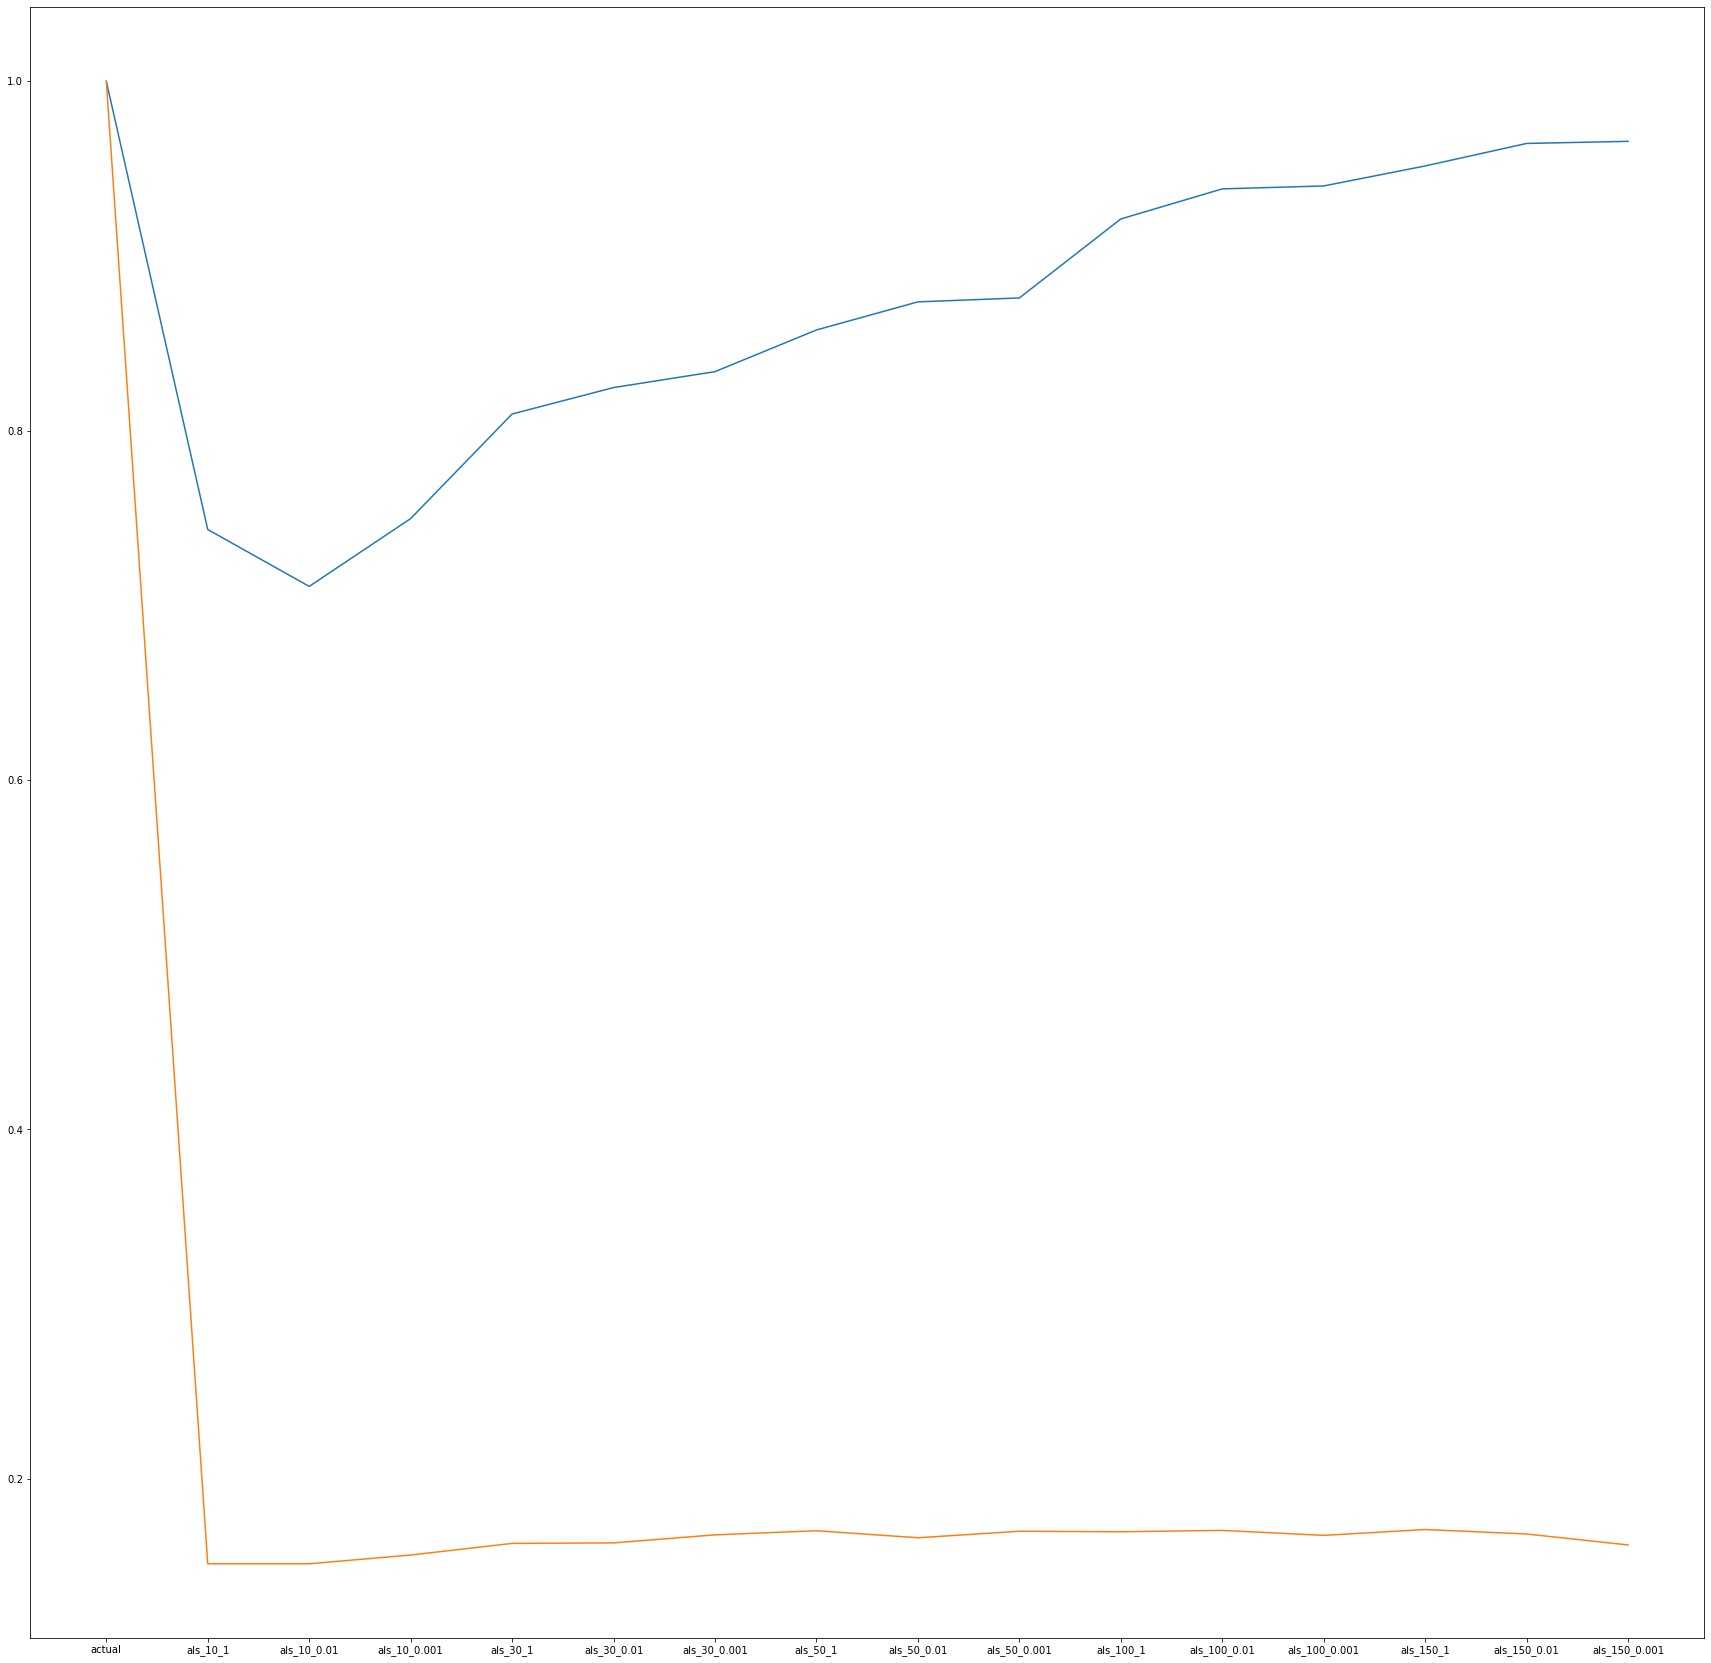

In [208]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(30,30)) 
x = metrics_train_opt.keys()
y1 = metrics_train_opt.values()
y2 = metrics_test_opt.values()
plt.plot(x, y1, y2)

**наилучший precision на тесте у модели с фактор = 100 и 150 (прямая зависимость кол-ва факторов и precision) и лямбда = 1, лямбда самая большая из списка, так как модель сильно переобучается. Хотелось бы, чтобы в разборе домашней работы Вы рассказали, как с этим справиться.
Так же неплохой результат у фактор = 100 и 50 с лямбдой 0.01 и 0.001, получается, что фактор все-таки лучше выбирать 50 или выше, а лямбду тестировать**

**Важно искать оптимальные параметры
regularization, iterations, factors, вес (элемент в матрице user-item)**